In [3]:
%matplotlib inline


# Wolfcamp Example - Bulk Process las files


This example shows the full petrophysical workflow avaiable in PetroPy
for a folder of wolfcamp las file courtesy of University Lands Texas.

The workflow progresses in 3 iterations to edit data, calculate the
petrophysical model, and to calculate statistics and save. To better
understand the worflow first read through the `single well`_ example.


The First Iteration

1. Read las file and create a :class:`petropy.Log` object
2. Create a :class:`petropy.LogViewer` show in edit_mode to fix data
3. Writes updated data to new folder via :meth:`petropy.Log.write`

The Second Iteration

1. Read las file and create a :class:`petropy.Log` object
2. Load tops from a csv file using :meth:`petropy.Log.tops_from_csv`
3. Calculate fluid properties by
    1. Loading parameters via :meth:`petropy.Log.fluid_properties_parameters_from_csv`
    2. Calculating over formations via :meth:`petropy.Log.formation_fluid_properties`
4. Calculate mulitmineral properties by
    1. Loading parameters via :meth:`petropy.Log.multimineral_parameters_from_csv`
    2. Calculating over formations via :meth:`petropy.Log.formation_multimineral_model`
5. Curve summations via :meth:`petropy.Log.summations`
6. Adding pay flags via :meth:`petropy.Log.add_pay_flag`

After the second iteration, the list processed_logs is used to perform
electrofacies calculations via :meth:`petropy.electrofacies`

The Third Iteration

1. Exporting log statistics via :meth:`petropy.Log.statistics`
2. Saving LogViewer to png and Log to las




D:\Anaconda\lib\site-packages\petropy\graphs.py:488: RuntimeWarning: invalid value encountered in greater
  where = v < x)
D:\Anaconda\lib\site-packages\petropy\graphs.py:489: RuntimeWarning: invalid value encountered in greater
  ax.plot(v * np.ones(len(self.log[0][v < x])),
D:\Anaconda\lib\site-packages\petropy\graphs.py:490: RuntimeWarning: invalid value encountered in greater
  self.log[0][v < x], c = "#000000", lw = 0.5)
D:\Anaconda\lib\site-packages\petropy\graphs.py:507: RuntimeWarning: invalid value encountered in less
  where = x < v)
D:\Anaconda\lib\site-packages\petropy\graphs.py:508: RuntimeWarning: invalid value encountered in less
  ax.plot(v * np.ones(len(self.log[0][x < v])),
D:\Anaconda\lib\site-packages\petropy\graphs.py:509: RuntimeWarning: invalid value encountered in less
  self.log[0][x < v], c = "#000000", lw = 0.5)


KeyError: 'WFMPA'

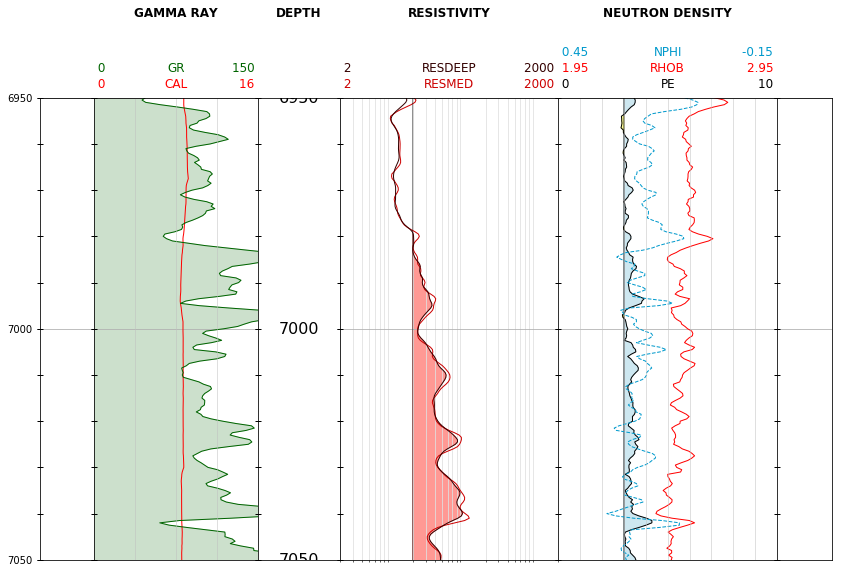

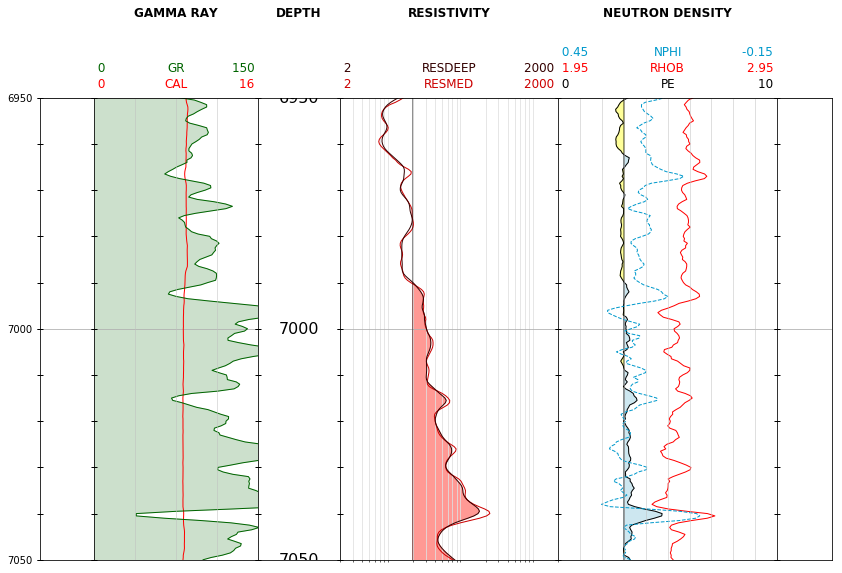

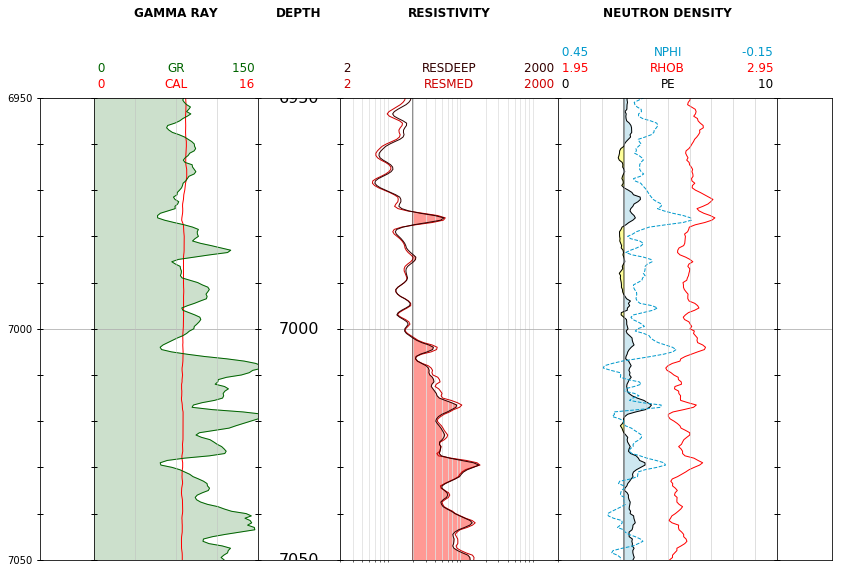

In [4]:
import petropy as ptr

# use glob to get file paths
import glob

# import pyplot to add logo to figure
import matplotlib.pyplot as plt


# define parameters                           #

f = ['WFMPA', 'WFMPB', 'WFMPC']
sum_curves = ['OIP', 'BVH', 'PHIE']
stats_curves = ['OIP', 'BVH', 'PHIE', 'SW', 'VCLAY', 'TOC']

flag_1_gtoe = [('PHIE', 0.03)]
flag_2_gtoe = [('PAY_FLAG_1', 1), ('BVH', 0.02)]
flag_3_gtoe = [('PAY_FLAG_2', 1)]
flag_3_ltoe = [('SW', 0.2)]

# get paths for all las files in folder       #
# wfmp_raw_las                                #

raw_las_folder = r'wfmp_raw_las/'
las_files = glob.glob(raw_las_folder + r'*.las')


### First Iteration ###

for las_file in las_files:


    ### 1. read raw las file ###

    # create a Log object by reading a file path  #

    log = ptr.Log(las_file)

    ### 2. graphically edit raw log ###

    # use manual mode for fixing borehole washout #
    # and other changes requiring redrawing data  #

    # use bulk shift mode to linearly adjust all  #
    # curve data                                  #

    # close both windows to continue program      #

    viewer = ptr.LogViewer(log, top = 6950, height = 100)
    #viewer.show(edit_mode = True)

    # overwrite log variable with updated log     #
    # from LogViewer edits                        #

    log = viewer.log

    # find way to name well, looking for well name#
    # or UWI or API                               #

    if len(log.well['WELL'].value) > 0:
        well_name = log.well['WELL'].value
    elif len(log.well['UWI'].value) > 0:
        well_name = str(log.well['UWI'].value)
    elif len(log.well['API'].value) > 0:
        well_name = str(log.well['API'].value)
    else:
        well_name = 'UNKNOWN'
    well_name = well_name.replace('.', '')

    # save changes to edited folder in case   #
    # reprocessing after editing is needed    #

    edited_log_file_name = 'wfmp_edited_las/%s_edited.las' % well_name
    # log.write(edited_log_file_name)

### Second Iteration ###

edited_file_folder = r'wfmp_edited_las/'
edited_las_files = glob.glob(edited_file_folder + r'*.las')

# create list to hold processed log objects   #

processed_logs = []

for las_file in edited_las_files:

    ### 1. Read las file ###

    log = ptr.Log(las_file)

    ### 2. load tops ###

    log.tops_from_csv('wfmp_raw_las/wfmp_tops.csv')

    ### 3. fluid properties ###

    # load fluid properties from a csv file       #
    # since path is not specified, load default   #
    # csv file included with petropy              #

    log.fluid_properties_parameters_from_csv()

    # calculate fluid properties over defined     #
    # formations with parameter WFMP from         #
    # previously loaded csv                       #

    log.formation_fluid_properties(f, parameter = 'WFMP')

    ### 4. multimineral model ###

    # load multimineral parameters from csv file  #
    # since path is not specified, load default   #
    # csv file included with petropy              #

    log.multimineral_parameters_from_csv()

    # calculate multiminearl model over defined   #
    # formations with parameter WFMP from         #
    # previously loaded csv                       #

    log.formation_multimineral_model(f, parameter = 'WFMP')

    ### 5. summations ###

    log.summations(f, curves = sum_curves)

    ### 6. pay flags ###

    log.add_pay_flag(f, greater_than_or_equal = flag_1_gtoe)
    log.add_pay_flag(f, greater_than_or_equal = flag_2_gtoe)
    log.add_pay_flag(f, greater_than_or_equal = flag_3_gtoe,
                     less_than_or_equal = flag_3_ltoe)

    # add log to processed_logs list              #

    processed_logs.append(log)


### 9. electrofacies ###

# define curves to use in electofaceis module #

electro_logs = ['GR_N', 'RESDEEP_N', 'NPHI_N', 'RHOB_N', 'PE_N']

# specifiy to use logarithmically scaled RESDEEP_N #

scaled = ['RESDEEP_N']

# calculate electrofacies for the processed logs #
final_logs = ptr.electrofacies(processed_logs, f,
                               electro_logs, 6, log_scale = scaled)


### Third Iteration ###

for log in final_logs:

    ### 1. export statistics ###

    log.statistics_to_csv('wfmp_processed_las/wfmp_statistics.csv',
                          replace = True, formations = f,
                          curves = stats_curves)

    ### 2. export data ###

    # find way to name well, looking for well name#
    # or UWI or API                               #

    if len(log.well['WELL'].value) > 0:
        well_name = log.well['WELL'].value
    elif len(str(log.well['UWI'].value)) > 0:
        well_name = str(log.well['UWI'].value)
    elif len(log.well['API'].value) > 0:
        well_name = str(log.well['API'].value)
    else:
        well_name = 'UNKNOWN'
    well_name = well_name.replace('.', '')

    # scale height of viewer to top and bottom    #
    # of calculated values                        #

    wfmpa_top = log.tops['WFMPA']
    wfmpc_base = log.next_formation_depth('WFMPC')

    top = wfmpa_top
    height = wfmpc_base - wfmpa_top

    # create LogViewer with the default full_oil #
    # template included in petropy               #

    viewer = ptr.LogViewer(log, top = top, height = height,
                           template_defaults = 'full_oil')

    # set viewer to 17x11 inches size for use in #
    # PowerPoint or printing to larger paper     #

    viewer.fig.set_size_inches(17, 11)

    # add well_name to title of LogViewer        #

    viewer.fig.suptitle(well_name, fontweight = 'bold', fontsize = 30)

    # add logo to top left corner                #

    logo_im = plt.imread('company_logo.png')
    logo_ax = viewer.fig.add_axes([0, 0.85, 0.2, 0.2])
    logo_ax.imshow(logo_im)
    logo_ax.axis('off')

    # add text to top right corner               #

    if len(str(log.well['UWI'].value)) > 0:
        label = 'UWI: ' + str(log.well['UWI'].value) + '\n'
    elif len(log.well['API'].value) > 0:
        label = 'API: ' + str(log.well['API'].value) + '\n'
    else:
        label = ''

    label += 'County: Reagan\nCreated By: Todd Heitmann\n'
    label += 'Creation Date: October 23, 2017'
    viewer.axes[0].annotate(label, xy = (0.99,0.99),
                        xycoords = 'figure fraction',
                        horizontalalignment = 'right',
                        verticalalignment = 'top',
                        fontsize = 14)

    # save figure and log                        #

    viewer_file_name=r'wfmp_processed_las/%s_processed.png' % well_name
    las_file_name = r'wfmp_processed_las/%s_processed.las' % well_name

    viewer.fig.savefig(viewer_file_name)
    viewer.log.write(las_file_name)